In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


## Reading data

In [3]:
xlsx = pd.ExcelFile('./Data/Outliers_out.xlsx')
>>> df = pd.read_excel(xlsx, '1x 5s')
dataset= df.copy()

# Exploring the data

In [4]:
dataset.head()
dataset.tail()

,DEPTH,SP,RHOB,NPHI,ILD,GR
4953,2054.3520,76.1875,2.252,0.2686,3.0955,64.3568
4954,2054.5044,76.1875,2.276,0.2686,3.1877,65.8693
4955,2054.6568,76.1875,2.326,0.2671,3.2799,67.3818
4956,2054.8092,76.3724,2.354,0.2759,3.3557,68.8871
4957,2054.9616,76.5731,2.356,0.2642,3.4302,70.3918


In [5]:
column_names = ['DEPTH', 'SP', 'RHOB', 'NPHI','ILD','GR']


## Clean the data

In [6]:
# If the dataset contains a few unknown values.

dataset.isna().sum()


#if so Drop those rows to keep this initial tutorial simple.

dataset = dataset.dropna()

#then confirm drop
dataset.isna().sum()

# help(dataset.sample)

DEPTH    0
SP       0
RHOB     0
NPHI     0
ILD      0
GR       0
dtype: int64

### Split the data into train and test

In [7]:
# the 'sample' method takes a certain fraction randomly
#Note that we use `random_state` to ensure the reproducibility of the examples.
train_dataset = dataset.sample(frac=0.7, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

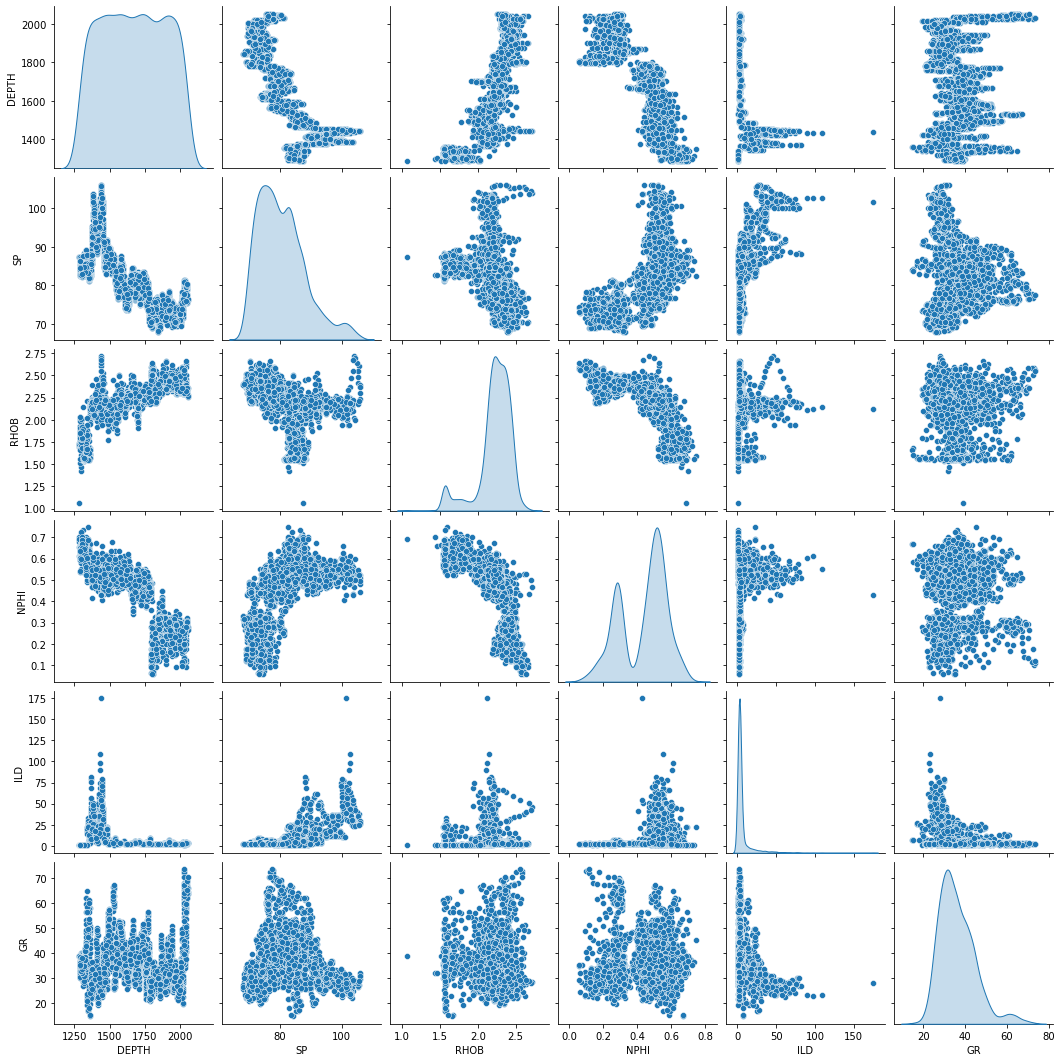

In [8]:
# Inspect the data
# Have a quick look at the joint distribution of a few pairs of columns from the training set.
# (   ) is a function of all the other parameters. Looking at the other rows it should be clear that they are functions of each other

sns.pairplot(train_dataset[column_names], diag_kind='kde')

In [9]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
DEPTH,3471.0,1669.686629,222.110993,1284.2748,1479.34680,1669.5420,1863.47100,2054.9616
SP,3471.0,80.522702,7.647740,67.8844,74.54185,79.2646,84.84455,106.0625
RHOB,3471.0,2.222204,0.218266,1.0600,2.15600,2.2580,2.36400,2.7200
NPHI,3471.0,0.436384,0.137932,0.0566,0.29790,0.4834,0.53760,0.7490
ILD,3471.0,5.920798,10.589117,0.5643,2.09885,2.6203,3.90730,175.0645
GR,3471.0,36.177188,8.811776,14.6057,29.86290,34.7130,41.05985,73.4426


##### Splitting the train and test data into input and target

In [10]:

# split datat into input and target

train_input = train_dataset.copy()
test_input = test_dataset.copy()

train_target = train_input.pop('RHOB')
test_target = test_input.pop('RHOB')




In [11]:

train_input.head()
# type(train_input)

,DEPTH,SP,NPHI,ILD,GR
933,1431.0360,99.3533,0.5659,26.4863,23.6097
3691,1861.2612,70.0695,0.3042,1.7244,30.0409
2730,1709.9280,77.9375,0.4263,3.5973,28.8262
142,1306.0680,82.7469,0.6216,0.6879,37.5992
3294,1795.8816,73.9070,0.1362,2.0932,27.7350


## normalization

#### The normalisation layer
#### Normalization layer is a clean and simple way to build that preprocessing into your model

In [12]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
DEPTH,1669.686629,222.110993
SP,80.522702,7.647740
RHOB,2.222204,0.218266
NPHI,0.436384,0.137932
ILD,5.920798,10.589117
GR,36.177188,8.811776


In [13]:
normalizer = preprocessing.Normalization()

#then adapt it to the data

normalizer.adapt(np.array(train_input))

# This calculates the mean and variance, and stores them in the layer.

print(normalizer.mean.numpy())

[1.6696866e+03 8.0522705e+01 4.3638378e-01 5.9207983e+00 3.6177189e+01]


In [ ]:
# This calculates the mean and variance, and stores them in the layer.


# print(normalizer.mean.numpy())
# # help(normalizer)
# x= np.copy(normalizer)
# # dir(x)
# x.view

# dir(preprocessing.Normalization)


In [14]:
# When the layer is called it returns the input data, with each feature independently normalized:


first = np.array(train_input[:2])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[1431.04   99.35    0.57   26.49   23.61]
 [1861.26   70.07    0.3     1.72   30.04]]

Normalized: [[-1.07  2.46  0.94  1.94 -1.43]
 [ 0.86 -1.37 -0.96 -0.4  -0.7 ]]


A DNN regression¶
These models will contain a few more layers than the linear model:

    1. The normalization layer.
    2. Two hidden, nonlinear, Dense layers using the relu nonlinearity.
    3. A linear single-output layer.

In [15]:
# First create the horsepower Normalization layer:


train_inputs = np.array(train_input)

train_inputs_normalizer = preprocessing.Normalization(input_shape=[5,])
train_inputs_normalizer.adapt(train_inputs)

In [115]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [17]:
# DNN model for multiple input: GR

In [116]:
    dnn_model = build_and_compile_model(normalizer)
    dnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 5)                 11        
_________________________________________________________________
dense_29 (Dense)             (None, 32)                192       
_________________________________________________________________
dense_30 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 17        
Total params: 748
Trainable params: 737
Non-trainable params: 11
_________________________________________________________________


In [117]:
%%time
mytraining = dnn_model.fit(
    train_inputs, train_target,
    # Calculate validation results on 30% of the training data
    validation_split=0.3,
     # suppress logging
    verbose=0,
    epochs=100)

Wall time: 8.56 s


In [19]:
#new 

weights = dnn_model.get_weights()

np.max(weights[0])
np.max(weights[1])

49319.082

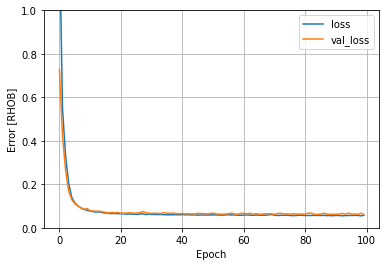

In [118]:
def plot_loss(arg):
  plt.plot(arg.history['loss'], label='loss')
  plt.plot(arg.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [RHOB]')
  plt.legend()
  plt.grid(True)


plot_loss(mytraining)

In [119]:
# collect the results in a set
test_results={}

test_results['dnn_model'] = dnn_model.evaluate(test_input, test_target, verbose=0)

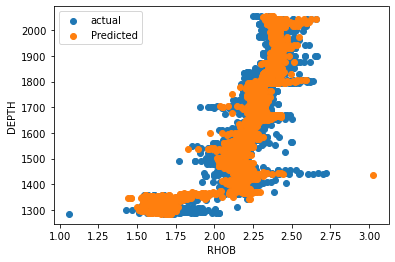

In [120]:

x=train_target
y = dnn_model.predict(train_input)

def plotScatter(x, y):
    plt.scatter(x, train_input['DEPTH'],  label='actual')
    plt.scatter( y,  train_input['DEPTH'], label='Predicted')
    plt.xlabel('RHOB')
    plt.ylabel('DEPTH')
    plt.legend()



plotScatter(x,y)





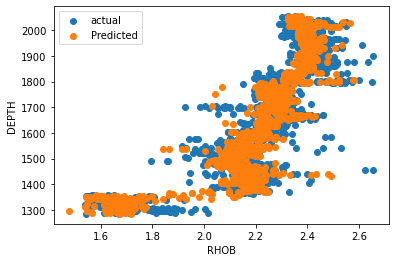

In [122]:
# A function to plot the predicted and actual target against a similar DEPTH using the test data(at validation)


test_target_actual=test_target

test_target_predicted = dnn_model.predict(test_input).flatten() ##Flattening converts multidimensional lists into one-dimensional lists


def plot_Scatter(target1, test_predict):
    plt.scatter(target1, test_input['DEPTH'],  label='actual')
    plt.scatter( test_predict,  test_input['DEPTH'], label='Predicted')
    plt.xlabel('RHOB')
    plt.ylabel('DEPTH')
    plt.legend()



    
plot_Scatter(test_target_actual,test_target_predicted)

# Performance

In [27]:
# To track the performance of all tested models stored in test_result
pd.DataFrame(test_results, index=['Mean absolute error [RHOB]']).T

,Mean absolute error [RHOB]
dnn_model,0.053237


In [ ]:
# Make predictions

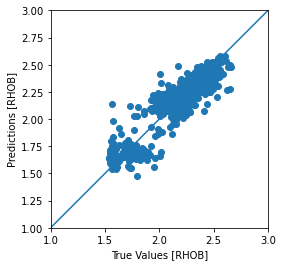

In [123]:
test_predictions = dnn_model.predict(test_input).flatten() #Flattening converts multidimensional lists into one-dimensional lists

a = plt.axes(aspect='equal')
plt.scatter(test_target, test_predictions)
plt.xlabel('True Values [RHOB]')
plt.ylabel('Predictions [RHOB]')
lims = [1, 3]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


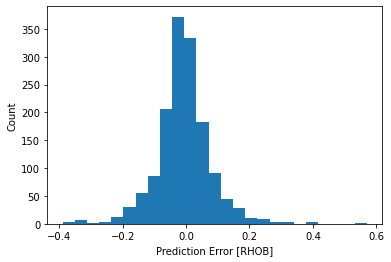

In [124]:
# Now take a look at the error distribution:

error = test_predictions - test_target
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [RHOB]')
_ = plt.ylabel('Count')


In [125]:

tf.keras.losses.MAE(
   test_target_actual,test_target_predicted
)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0600619>

In [35]:
# # r squared
# #
# metric = tfa.metrics.r_square.RSquare()
# metric.update_state(test_target, test_predictions)
# result = metric.result()
# result.numpy()

In [127]:
# Testing model on different wells

xlsx = pd.ExcelFile('./Data/Outliers_out.xlsx')
df = pd.read_excel(xlsx, '1x 4s')
dataset4s= df.copy()


In [128]:
# splitting the data

# train_dataset = dataset.sample(frac=0.7, random_state=0)
# test_dataset = dataset.drop(train_dataset.index)


# split datat into input and target

# train_input = train_dataset.copy()
# test_input = test_dataset.copy()

# train_target = train_input.pop('RHOB')
# test_target = test_input.pop('RHOB')

# test_dataset = dataset.drop(train_dataset.index)


trial4s_input= dataset4s.copy() 
trial4s_target=trial4s_input.pop('RHOB')

trial4s_input.head()
trial4s_target.head()

0    1.7092
1    1.7035
2    1.6942
3    1.6868
4    1.6838
Name: RHOB, dtype: float64

In [129]:
# test it with model

dnn_model.evaluate(trial4s_input,trial4s_target, verbose=0)




0.2485637664794922

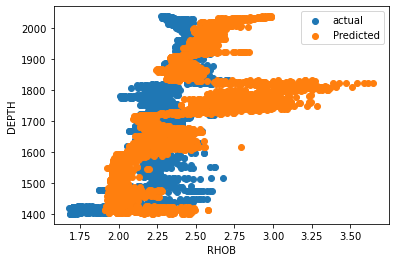

In [130]:
#where i try to compare the predicted and the actual target against the DEPTH

x=trial4s_target
y = dnn_model.predict(trial4s_input)

def plotScatter(x, y):
    plt.scatter(x, trial4s_input['DEPTH'],  label='actual')
    plt.scatter( y, trial4s_input['DEPTH'], label='Predicted')
    plt.xlabel('RHOB')
    plt.ylabel('DEPTH')
    plt.legend()



plotScatter(x,y)

slope is [1.04196634]


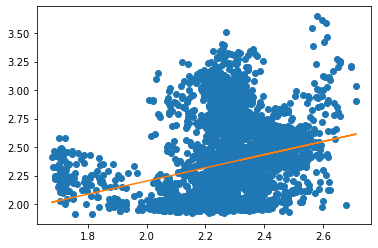

In [131]:
def plotRegression(actual, predicted):
    plt.plot(actual, predicted, "o") #create the scatter plot
    m, b = np.polyfit(actual, predicted, 1) #m=slope b=intercept
    plt.plot(x, m*x + b) #add line of bestfit
    print("slope is" , np.array(b))
    
    
plotRegression(x,y)    


slope of best fit is [0.58013073]


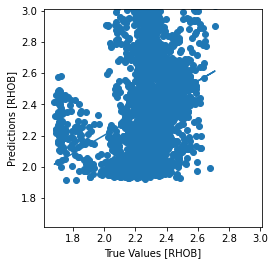

In [133]:
def plot_regression(true,predicted):
    a = plt.axes(aspect='equal')
    plt.scatter(true, predicted)
    plt.xlabel('True Values [RHOB]')
    plt.ylabel('Predictions [RHOB]')
#     lims = [1, 3]
    lims =[min(predicted)-0.3,max(true)+0.3]
    plt.xlim(lims)
    plt.ylim(lims)
#     _ = plt.plot(lims, lims)
    m, b = np.polyfit(true, predicted, 1) #m=slope b=intercept
    plt.plot(x, m*x + b) #add line of bestfit
    print("slope of best fit is", m)

plot_regression(x,y)

In [140]:
# import matplotlib.pyplot as plt
# from matplotlib import style
# # style.use('ggplot')

# # regression_line = [(m*x)+b for x in x]
# plt.scatter(x,y,color='#003F72')
# plt.plot(x, regression_line)
# # plt.show()

# L2 regularization
### is to force our weights to be as small as possible

In [43]:
def build_and_compile_model_Regularized(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu', kernel_regularizer="l2"),
      layers.Dense(64, activation='relu', kernel_regularizer="l2"),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [44]:
    reg_dnn_model = build_and_compile_model_Regularized(normalizer)
    reg_dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 5)                 11        
_________________________________________________________________
dense_3 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,620
Trainable params: 4,609
Non-trainable params: 11
_________________________________________________________________


In [45]:
%%time
reg_mytraining = reg_dnn_model.fit(
    train_inputs, train_target,
     validation_data=(test_input, test_target),
    # Calculate validation results on 30% of the training data
    validation_split=0.3,
     # suppress logging
    verbose=0,
    epochs=200)

Wall time: 16.8 s


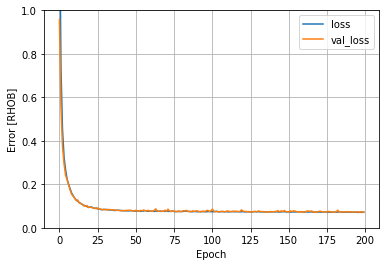

In [46]:
def plot_loss(arg):
  plt.plot(arg.history['loss'], label='loss')
  plt.plot(arg.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [RHOB]')
  plt.legend()
  plt.grid(True)


plot_loss(reg_mytraining)

In [47]:
test_results={}

test_results['reg_dnn_model '] = reg_dnn_model.evaluate(test_input, test_target, verbose=0)

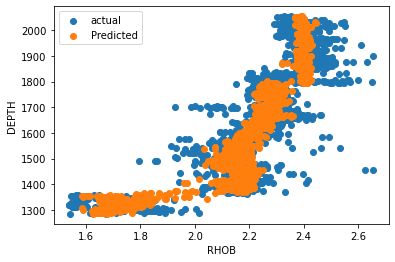

In [50]:
test_target_actual=test_target

reg_target_predicted = reg_dnn_model.predict(test_input).flatten() ##Flattening converts multidimensional lists into one-dimensional lists

plot_Scatter(test_target_actual,reg_target_predicted)

slope of best fit is 0.8011748321480457


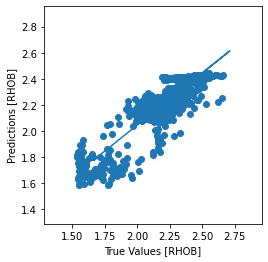

In [52]:
# a = plt.axes(aspect='equal')
# plt.scatter(test_target_actual,reg_target_predicted)
# plt.xlabel('True Values [RHOB]')
# plt.ylabel('Predictions [RHOB]')
# lims = [1, 3]
# plt.xlim(lims)
# plt.ylim(lims)
# _ = plt.plot(lims, lims)


def plot_regression(true,predicted):
    a = plt.axes(aspect='equal')
    plt.scatter(true, predicted)
    plt.xlabel('True Values [RHOB]')
    plt.ylabel('Predictions [RHOB]')
#     lims = [1, 3]
    lims =[min(predicted)-0.3,max(true)+0.3]
    plt.xlim(lims)
    plt.ylim(lims)
#     _ = plt.plot(lims, lims)
    m, b = np.polyfit(true, predicted, 1) #m=slope b=intercept
    plt.plot(x, m*x + b) #add line of bestfit
    print("slope of best fit is", m)


plot_regression(test_target_actual,reg_target_predicted)


In [70]:
#plot decision boundary

from mlxtend.plotting import plot_decision_regions

def plot_decision_boundary(test_inp, test_outputs):
    plot_decision_regions(test_inp, test_outputs.ravel(), clf= model, legend=2)
    plot.show
    
    
plot_decision_boundary(test_target_actual,reg_target_predicted)    

NameError: name 'model' is not defined

# Dropout



In [108]:
def build_and_compile_model_Dropout(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(16, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [109]:
    drop_dnn_model = build_and_compile_model_Dropout(normalizer)
    drop_dnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 5)                 11        
_________________________________________________________________
dense_26 (Dense)             (None, 32)                192       
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 17        
Total params: 748
Trainable params: 737
Non-trainable params: 11
_______________________________________________________

In [111]:
%%time
drop_mytraining = drop_dnn_model.fit(
    train_inputs, train_target,
    validation_data=(test_input, test_target),
    # Calculate validation results on 30% of the training data
    validation_split=0.3,
     # suppress logging
    verbose=0,
    epochs=100)

Wall time: 8.99 s


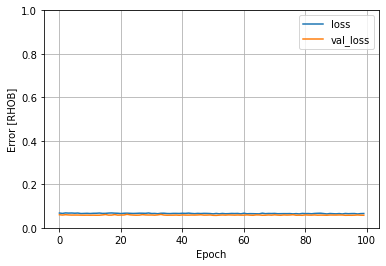

In [112]:
def plot_loss(arg):
  plt.plot(arg.history['loss'], label='loss')
  plt.plot(arg.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [RHOB]')
  plt.legend()
  plt.grid(True)


plot_loss(drop_mytraining)

In [113]:
test_results={}

test_results['drop_dnn_model '] = drop_dnn_model.evaluate(test_input, test_target, verbose=0)

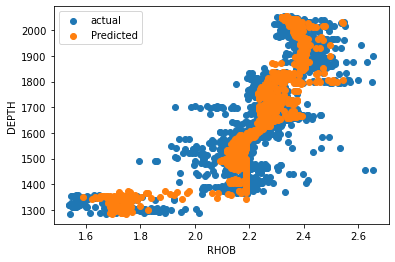

In [114]:
test_target_actual=test_target

drop_target_predicted = drop_dnn_model.predict(test_input).flatten() ##Flattening converts multidimensional lists into one-dimensional lists

plot_Scatter(test_target_actual,drop_target_predicted)

In [65]:
#plot decision boundary

from mlxtend.plotting import plot_decision_regions

def plot_decision_boundary(test_inp, test_outputs):
    plot_decision_regions(test_inp, test_outputs.ravel(), clf= model, legend=2)
    plot.show
    
    
plot_decision_boundary(test_inputs,test_target)    

NameError: name 'test_inputs' is not defined

# early stoping 


In [76]:
def build_and_compile_model_Dropout_stop(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(64, activation='relu'),
      layers.Dense(0.5),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [77]:
    stop_drop_dnn_model = build_and_compile_model_Dropout_stop(normalizer)
    stop_drop_dnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 5)                 11        
_________________________________________________________________
dense_13 (Dense)             (None, 64)                384       
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 0)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 1         
Total params: 4,556
Trainable params: 4,545
Non-trainable params: 11
___________________________________________________

In [97]:
%%time
stop_drop_mytraining = stop_drop_dnn_model.fit(
    train_inputs, train_target,
    validation_data=(test_input, test_target),
    # Calculate validation results on 30% of the training data
    validation_split=0.3,
     # suppress logging
    verbose=1,
    epochs=200,
    #the fuction to stop the trianing by tracking the validation loss
    callbacks= keras.callbacks.EarlyStopping(monitor='val_loss',patience=3) #patience=3
    )

Epoch 1/200
76/76 [==============================] - 0s 5ms/step - loss: 2.2216 - val_loss: 2.2235
Epoch 2/200
76/76 [==============================] - 0s 6ms/step - loss: 2.2216 - val_loss: 2.2235
Epoch 3/200
76/76 [==============================] - 0s 6ms/step - loss: 2.2216 - val_loss: 2.2235
Epoch 4/200
76/76 [==============================] - 0s 6ms/step - loss: 2.2216 - val_loss: 2.2235
Wall time: 1.8 s


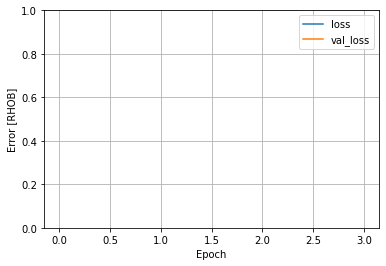

In [98]:
plot_loss(stop_drop_mytraining)

In [94]:
# help(plot_decision_regions)
# help(test_target.ravel)
plot_decision_regions(test_input, test_target.ravel(), clf=stop_drop_dnn_model, legend=2)
plot.show


AttributeError: 'DataFrame' object has no attribute 'ravel'

In [96]:
# To track the performance of all tested models stored in test_result
# pd.DataFrame(test_results, index=['Mean absolute error [RHOB]']).T

test_results

{'drop_dnn_model ': 0.06110333278775215}

In [ ]:
# Save the model(s)
dnn_model.save('dnn_model')

In [ ]:
#To reload the model,
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [42]:
# To compare all the models employed
pd.DataFrame(test_results, index=['Mean absolute error [RHOB]']).T

,mean squared error [RHOB]
dnn_model,0.058294
